In [1]:
%%time
#print("1")
import tensorflow as tf
from numba import cuda
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras.preprocessing.sequence import pad_sequences
#print("2")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pickle
from keras.layers import Dense, Input, Dropout
#print("3")
from keras import Sequential
#print("4")
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import keras
print(keras.__version__)
from sklearn.model_selection import train_test_split
from keras.constraints import maxnorm
import numpy as np
from sklearn.metrics import roc_auc_score
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate, Activation, Reshape,Conv2D
from keras.models import Model
from keras.initializers import Constant
from keras.layers import MaxPool2D
from keras import regularizers

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7669063144665208027
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12165094337540337803
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7101115018290859536
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15870492672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7270625426427445481
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


Using TensorFlow backend.


2.3.1
CPU times: user 3.54 s, sys: 1.19 s, total: 4.73 s
Wall time: 11.5 s


In [2]:
def plot_history(history,model):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, accuracy, 'b', label='Training accuracy')
    plt.plot(x, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy of '+model)
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss of '+model)
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(x, auc, 'b', label='Training auc')
    plt.plot(x, val_auc, 'r', label='Validation auc')
    plt.title('Training and validation auc of '+model)
    plt.legend()

In [3]:
%%time
# preprocessing
with open(r"../input/challengedadata/comments.txt", "rb") as f:
    clean_train_comments = pickle.load(f) 
    f.close()

with open(r"../input/challengedadata/targets.txt", "rb") as ft:
    y= pickle.load(ft) 
    ft.close()

    
y = [int(s) for s in y]


# model1 suggested parameters
max_features = 5000
maxlen = 400


clean_train,clean_valid,y_train,y_valid = train_test_split(clean_train_comments,y, train_size = 0.8, test_size = 0.2, random_state = 0)



#keras tokenization
print("keras tokenizing")
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(clean_train)
print("keras trasforming")
X_train = tokenizer.texts_to_sequences(clean_train)
X_valid = tokenizer.texts_to_sequences(clean_valid)
vocab_size = len(tokenizer.word_index) + 1 
maxlen = 400
print("keras padding")
X_train_pad =  pad_sequences(X_train, padding='post', maxlen=maxlen, dtype='float32')  #maxlen_train
X_valid_pad = pad_sequences(X_valid, padding='post', maxlen=maxlen, dtype='float32') #maxlen_train 
# end of keras tokenization


keras tokenizing
keras trasforming
keras padding
CPU times: user 18.2 s, sys: 124 ms, total: 18.4 s
Wall time: 18.4 s


In [4]:
# create embedding matrix
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

print("obtaining embedding matrix")
embedding_dim = 300
embedding_matrix = create_embedding_matrix('../input/nlpword2vecembeddingspretrained/glove.6B.300d.txt',tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print("nonzero_elements / vocab_size = ", nonzero_elements / vocab_size)

obtaining embedding matrix
nonzero_elements / vocab_size =  0.599022781283291


In [5]:
# Define the models.

METRICS = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.AUC(name='auc')]

def model0():  # from https://medium.com/@am.benatmane/keras-hyperparameter-tuning-using-sklearn-pipelines-grid-search-with-cross-validation-ccfc74b0ce9f

    embedding_dim = 300 #50 gives 0.5
    maxlen = 400
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                            weights=[embedding_matrix],
                           input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)
    return model
    
def model1():  #0.8 from
    max_features = 5000
    maxlen = 400
    batch_size = 32
    embedding_dims = 300 #100 #200 #50
    filters = 400 #250
    kernel_size = 5 #3
    hidden_dims = 350 #250
    epochs = 2
        
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(vocab_size,   #max_features
                        embedding_dims,
                        weights=[embedding_matrix],
                        input_length=maxlen,
                        trainable = True)) #False -> 83 (e False uguale)
    model.add(Dropout(0.1)) #0.2

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1)) #1
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.1)) #0.2
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)


    return model


def model2():  #0.78
    embedding_dim = 300
    maxlen = 400
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=METRICS)
    return model



def model3():
    maxlen = 400
    embedding_dims = 300
    dense = 10
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=True))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(dense, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=METRICS)
    return model


# Kim Yoon CNN
def model4(): #0.7
    maxlen = 400
    embedding_dim = 300
    sequence_input = Input(shape=(maxlen,), dtype='int32')

    embedding_layer = Embedding(vocab_size,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=maxlen,
                                trainable=True)

    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [3,5,7]

    for fsz in filter_sizes:
        x = Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences) #"same"
        x = MaxPooling1D()(x)
        convs.append(x)

    x = Concatenate(axis=-1)(convs)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(sequence_input, output)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)
    return model

def model5(): #0.6
    maxlen = 400
    embedding_dim = 300
    num_filters = 100
    inputs_4 = Input(shape=(maxlen,), dtype='int32')
    embedding_layer_4 = Embedding(vocab_size,
                                embedding_dim,
                                embeddings_initializer=Constant(embedding_matrix), #embeddings_initializer=Constant(embedding_matrix)
                                input_length=maxlen,
                                trainable=True)(inputs_4)

    reshape_4 = Reshape((maxlen, embedding_dim, 1))(embedding_layer_4)

    conv_0_4 = Conv2D(num_filters, kernel_size=(3, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_4)
    conv_1_4 = Conv2D(num_filters, kernel_size=(4, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_4)
    conv_2_4 = Conv2D(num_filters, kernel_size=(5, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_4)

    maxpool_0_4 = MaxPool2D(pool_size=(maxlen - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_4)
    maxpool_1_4 = MaxPool2D(pool_size=(maxlen - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_4)
    maxpool_2_4 = MaxPool2D(pool_size=(maxlen - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_4)

    concatenated_tensor_4 = Concatenate(axis=1)([maxpool_0_4, maxpool_1_4, maxpool_2_4])
    flatten_4 = Flatten()(concatenated_tensor_4)

    dropout_4 = Dropout(0.5)(flatten_4) #0.5
    # note the different activation
    output_4 = Dense(units=1, activation='sigmoid')(dropout_4)
    model_4 = Model(inputs=inputs_4, outputs=output_4)

    # note we're using binary_crossentropy here instead of categorical
    model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
    return model_4


def model6():
    maxlen = 400
    embedding_dim = 300
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=True))
    model.add(Conv1D(128, 7, activation='relu',padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(256, 5, activation='relu',padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(512, 3, activation='relu',padding='same'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5)) #0.5
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=METRICS)
    return model


def model7(): #0.84 (best)
    maxlen = 400
    embedding_dim = 300
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=True))
    model.add(Conv1D(512, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2)) #0.5
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=METRICS)
    return model


def model8():
    #     def define_model(length, vocab_size):
    # channel 1
    maxlen = 400
    embedding_dim = 300
    inputs1 = Input(shape=(maxlen,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(maxlen,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(maxlen,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
    # summarize
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [6]:
# individual callbacks
class MyCustomCallback0(tf.keras.callbacks.Callback):

    
    def on_epoch_end(self,epoch, logs=None):
        y_pred = model0.predict_proba(X_valid_pad)
        print("roc evaluated with scikit = ",roc_auc_score(y_valid, y_pred))
        return
    
class MyCustomCallback1(tf.keras.callbacks.Callback):

    
    def on_epoch_end(self,epoch, logs=None):
        y_pred = model1.predict_proba(X_valid_pad)
        print("roc evaluated with scikit = ",roc_auc_score(y_valid, y_pred))
        return
    
class MyCustomCallback2(tf.keras.callbacks.Callback):

    
    def on_epoch_end(self,epoch, logs=None):
        y_pred = model2.predict_proba(X_valid_pad)
        print("roc evaluated with scikit = ",roc_auc_score(y_valid, y_pred))
        return
    
class MyCustomCallback3(tf.keras.callbacks.Callback):

    
    def on_epoch_end(self,epoch, logs=None):
        y_pred = model3.predict_proba(X_valid_pad)
        print("roc evaluated with scikit = ",roc_auc_score(y_valid, y_pred))
        return
    
class MyCustomCallback4(tf.keras.callbacks.Callback):

    
    def on_epoch_end(self,epoch, logs=None):
        y_pred = model4.predict(X_valid_pad)
        print("roc evaluated with scikit = ",roc_auc_score(y_valid, y_pred))
        return
    

class MyCustomCallback5(tf.keras.callbacks.Callback):

    
    def on_epoch_end(self,epoch, logs=None):
        y_pred = model5.predict(X_valid_pad)
        print("roc evaluated with scikit = ",roc_auc_score(y_valid, y_pred))
        return
    
class MyCustomCallback6(tf.keras.callbacks.Callback):

    
    def on_epoch_end(self,epoch, logs=None):
        y_pred = model6.predict_proba(X_valid_pad)
        print("roc evaluated with scikit = ",roc_auc_score(y_valid, y_pred))
        return
    
class MyCustomCallback7(tf.keras.callbacks.Callback):

    
    def on_epoch_end(self,epoch, logs=None):
        y_pred = model7.predict_proba(X_valid_pad)
        print("roc evaluated with scikit = ",roc_auc_score(y_valid, y_pred))
        return
    

MODEL0


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4000 samples, validate on 1000 samples
Epoch 1/8
4000/4000 [==============================] - 8s 2ms/step - loss: 0.8244 - accuracy: 0.6924 - auc: 0.5807 - val_loss: 0.8729 - val_accuracy: 0.6971 - val_auc: 0.6066
roc evaluated with scikit =  0.6083848177147052
Epoch 2/8
4000/4000 [==============================] - 7s 2ms/step - loss: 0.2411 - accuracy: 0.7456 - auc: 0.7104 - val_loss: 1.0792 - val_accuracy: 0.7777 - val_auc: 0.7719
roc evaluated with scikit =  0.6787935323383085
Epoch 3/8
4000/4000 [==============================] - 7s 2ms/step - loss: 0.0955 - accuracy: 0.8060 - auc: 0.8143 - val_loss: 0.7576 - val_accuracy: 0.8257 - val_auc: 0.8463
roc evaluated with scikit =  0.7171876274365876
Epoch 4/8
4000/4000 [==============================] - 7s 2ms/step - loss: 0.0370 - accuracy: 0.8419 - auc: 0.8689 - val_loss: 0.9934 - val_accuracy: 0.8547 - val_auc: 0.8845
roc evaluated with scikit =  0.6965785824973493
Epoch 5/8
4000/4000 [==============================] - 7s 2m

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4000 samples, validate on 1000 samples
Epoch 1/4
4000/4000 [==============================] - 6s 2ms/step - loss: 0.5609 - accuracy: 0.8899 - auc: 0.9249 - val_loss: 0.4606 - val_accuracy: 0.8820 - val_auc: 0.9181
roc evaluated with scikit =  0.815818448739907
Epoch 2/4
4000/4000 [==============================] - 3s 722us/step - loss: 0.3719 - accuracy: 0.8791 - auc: 0.9148 - val_loss: 0.4352 - val_accuracy: 0.8766 - val_auc: 0.9125
roc evaluated with scikit =  0.830855966071283
Epoch 3/4
4000/4000 [==============================] - 3s 706us/step - loss: 0.1813 - accuracy: 0.8778 - auc: 0.9136 - val_loss: 0.4901 - val_accuracy: 0.8791 - val_auc: 0.9153
roc evaluated with scikit =  0.8266046815104803
Epoch 4/4
4000/4000 [==============================] - 3s 702us/step - loss: 0.0483 - accuracy: 0.8822 - auc: 0.9187 - val_loss: 0.6963 - val_accuracy: 0.8847 - val_auc: 0.9213
roc evaluated with scikit =  0.8336901557784845
MODEL2


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4000 samples, validate on 1000 samples
Epoch 1/4
4000/4000 [==============================] - 6s 2ms/step - loss: 0.5710 - accuracy: 0.8793 - auc: 0.9153 - val_loss: 0.5306 - val_accuracy: 0.8733 - val_auc: 0.9098
roc evaluated with scikit =  0.7741925617812576
Epoch 2/4
4000/4000 [==============================] - 6s 2ms/step - loss: 0.4692 - accuracy: 0.8685 - auc: 0.9060 - val_loss: 0.4627 - val_accuracy: 0.8651 - val_auc: 0.9033
roc evaluated with scikit =  0.804379740641057
Epoch 3/4
4000/4000 [==============================] - 6s 2ms/step - loss: 0.3372 - accuracy: 0.8645 - auc: 0.9025 - val_loss: 0.4682 - val_accuracy: 0.8636 - val_auc: 0.9018
roc evaluated with scikit =  0.8078562107495311
Epoch 4/4
4000/4000 [==============================] - 6s 2ms/step - loss: 0.2183 - accuracy: 0.8648 - auc: 0.9030 - val_loss: 0.4863 - val_accuracy: 0.8656 - val_auc: 0.9039
roc evaluated with scikit =  0.7967131555338064
MODEL3


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 6s 2ms/step - loss: 0.5766 - accuracy: 0.8619 - auc: 0.8993 - val_loss: 0.5415 - val_accuracy: 0.8578 - val_auc: 0.8948
roc evaluated with scikit =  0.7593283582089552
Epoch 2/5
4000/4000 [==============================] - 6s 2ms/step - loss: 0.5073 - accuracy: 0.8544 - auc: 0.8917 - val_loss: 0.4994 - val_accuracy: 0.8507 - val_auc: 0.8892
roc evaluated with scikit =  0.8122527730201452
Epoch 3/5
4000/4000 [==============================] - 6s 2ms/step - loss: 0.4131 - accuracy: 0.8487 - auc: 0.8885 - val_loss: 0.4708 - val_accuracy: 0.8472 - val_auc: 0.8880
roc evaluated with scikit =  0.8231791860370279
Epoch 4/5
4000/4000 [==============================] - 6s 2ms/step - loss: 0.3322 - accuracy: 0.8472 - auc: 0.8887 - val_loss: 0.4524 - val_accuracy: 0.8474 - val_auc: 0.8894
roc evaluated with scikit =  0.8248358616752303
Epoch 5/5
4000/4000 [==============================] - 6s 2m

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 10s 3ms/step - loss: 0.5965 - accuracy: 0.8473 - auc: 0.8892 - val_loss: 0.4865 - val_accuracy: 0.8450 - val_auc: 0.8864
roc evaluated with scikit =  0.7925995024875622
Epoch 2/5
4000/4000 [==============================] - 10s 3ms/step - loss: 0.3603 - accuracy: 0.8448 - auc: 0.8863 - val_loss: 0.4826 - val_accuracy: 0.8444 - val_auc: 0.8860
roc evaluated with scikit =  0.805547059783052
Epoch 3/5
4000/4000 [==============================] - 10s 2ms/step - loss: 0.1495 - accuracy: 0.8460 - auc: 0.8880 - val_loss: 0.6464 - val_accuracy: 0.8472 - val_auc: 0.8896
roc evaluated with scikit =  0.7711034988989478
Epoch 4/5
4000/4000 [==============================] - 10s 2ms/step - loss: 0.0483 - accuracy: 0.8491 - auc: 0.8921 - val_loss: 0.9720 - val_accuracy: 0.8508 - val_auc: 0.8941
roc evaluated with scikit =  0.7806816328195091
Epoch 5/5
4000/4000 [==============================] - 10

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 3s 817us/step - loss: 939.7182 - accuracy: 0.8511 - auc: 0.8934 - val_loss: 165.3696 - val_accuracy: 0.8483 - val_auc: 0.8896
roc evaluated with scikit =  0.6006901965581927
Epoch 2/5
4000/4000 [==============================] - 3s 652us/step - loss: 59.0929 - accuracy: 0.8462 - auc: 0.8864 - val_loss: 12.2261 - val_accuracy: 0.8440 - val_auc: 0.8833
roc evaluated with scikit =  0.6114305521572466
Epoch 3/5
4000/4000 [==============================] - 3s 654us/step - loss: 4.8580 - accuracy: 0.8421 - auc: 0.8802 - val_loss: 1.4947 - val_accuracy: 0.8401 - val_auc: 0.8771
roc evaluated with scikit =  0.6043527240844956
Epoch 4/5
4000/4000 [==============================] - 3s 651us/step - loss: 0.9331 - accuracy: 0.8382 - auc: 0.8740 - val_loss: 0.6719 - val_accuracy: 0.8364 - val_auc: 0.8710
roc evaluated with scikit =  0.6375550526058233
Epoch 5/5
4000/4000 [=========================

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5709 - accuracy: 0.8314 - auc: 0.8621 - val_loss: 0.5270 - val_accuracy: 0.8299 - val_auc: 0.8599
roc evaluated with scikit =  0.7290137427616018
Epoch 2/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.4875 - accuracy: 0.8290 - auc: 0.8589 - val_loss: 0.4774 - val_accuracy: 0.8284 - val_auc: 0.8582
roc evaluated with scikit =  0.8135602724084495
Epoch 3/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.3247 - accuracy: 0.8287 - auc: 0.8589 - val_loss: 0.5416 - val_accuracy: 0.8289 - val_auc: 0.8595
roc evaluated with scikit =  0.8067729997553217
Epoch 4/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.1903 - accuracy: 0.8299 - auc: 0.8612 - val_loss: 0.7565 - val_accuracy: 0.8308 - val_auc: 0.8627
roc evaluated with scikit =  0.8051341652393769
Epoch 5/5
4000/4000 [==============================] - 9s 2m

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5378 - accuracy: 0.8321 - auc: 0.8633 - val_loss: 0.5647 - val_accuracy: 0.8310 - val_auc: 0.8617
roc evaluated with scikit =  0.8103947475736075
Epoch 2/5
4000/4000 [==============================] - 4s 1ms/step - loss: 0.3909 - accuracy: 0.8306 - auc: 0.8613 - val_loss: 0.4186 - val_accuracy: 0.8305 - val_auc: 0.8614
roc evaluated with scikit =  0.839766332273061
Epoch 3/5
4000/4000 [==============================] - 4s 1ms/step - loss: 0.2167 - accuracy: 0.8314 - auc: 0.8628 - val_loss: 0.4701 - val_accuracy: 0.8321 - val_auc: 0.8640
roc evaluated with scikit =  0.8327114427860698
Epoch 4/5
4000/4000 [==============================] - 4s 1ms/step - loss: 0.0712 - accuracy: 0.8335 - auc: 0.8662 - val_loss: 0.9298 - val_accuracy: 0.8348 - val_auc: 0.8676
roc evaluated with scikit =  0.824412772204551
Epoch 5/5
4000/4000 [==============================] - 4s 1ms/

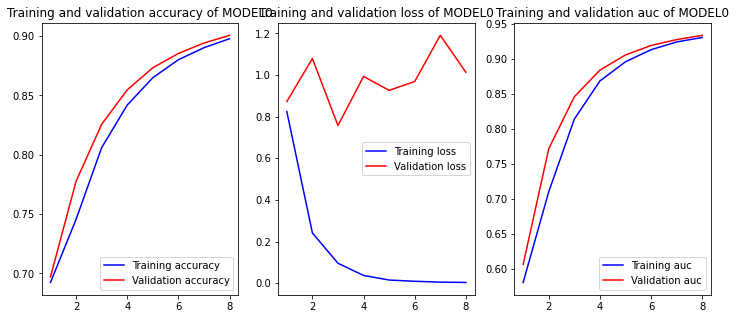

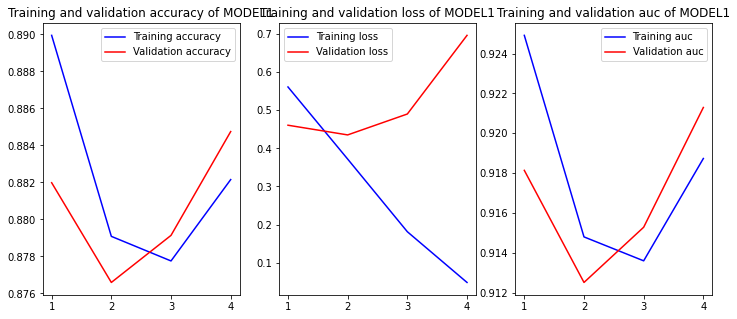

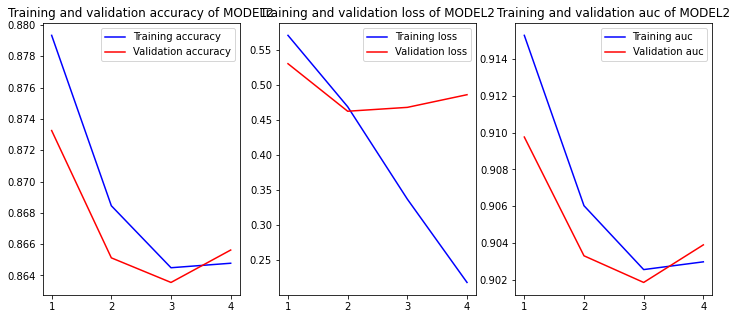

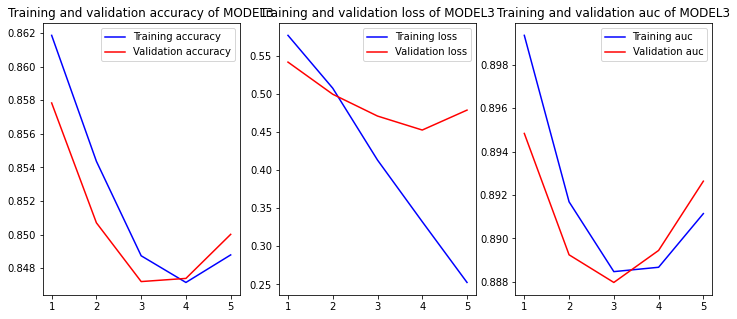

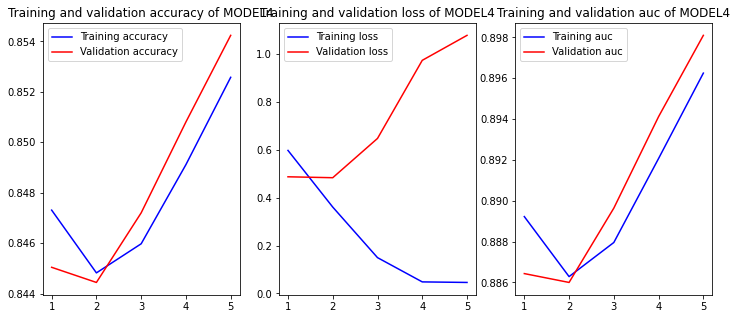

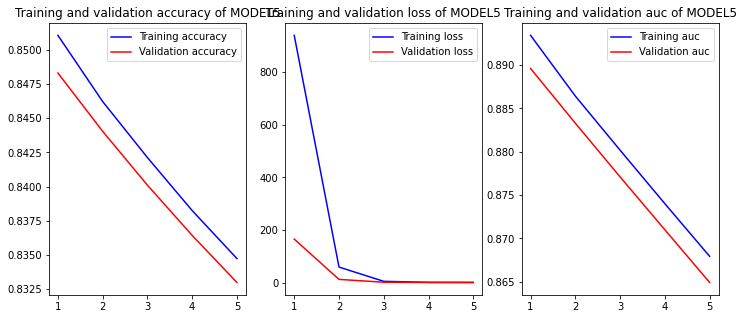

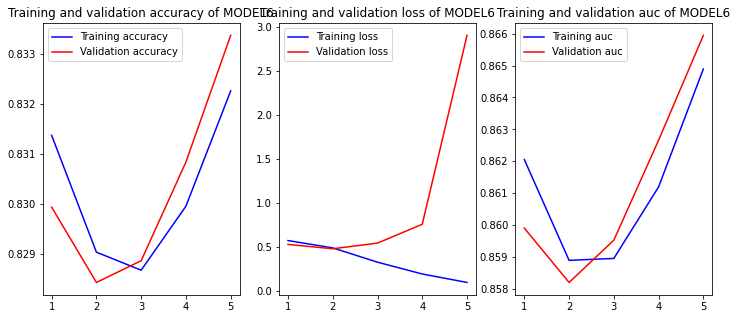

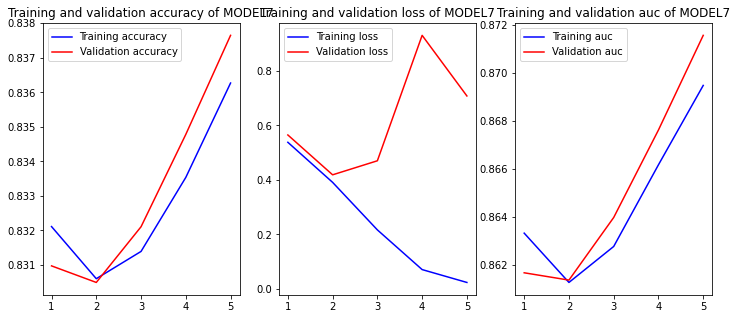

In [7]:
# early stopping

callbacks = EarlyStopping(
        monitor='val_loss', # val_accuracy
        min_delta=1e-2,
        patience=2, #2
        verbose=10)


# model training




#8
print("MODEL0")
model0 = model0()
history0 = model0.fit(x=X_train_pad, y=y_train, batch_size = 8, epochs = 8, verbose=1,validation_data = (X_valid_pad,y_valid), callbacks=[MyCustomCallback0()], shuffle=True, validation_freq=1, max_queue_size=10, workers=4, use_multiprocessing=True) #, callbacks=callbacks , validation_split=0.2
plot_history(history0,"MODEL0")

#4
print("MODEL1")
model1 = model1()
history1 = model1.fit(x=X_train_pad, y=y_train, batch_size = 32, epochs = 4, verbose=1,validation_data = (X_valid_pad,y_valid), callbacks=[MyCustomCallback1()], shuffle=True, validation_freq=1, max_queue_size=10, workers=4, use_multiprocessing=True) #, callbacks=callbacks , validation_split=0.2
plot_history(history1,"MODEL1")

#4
print("MODEL2")
model2 = model2()
history2 = model2.fit(x=X_train_pad, y=y_train, batch_size = 8, epochs = 4, verbose=1,validation_data = (X_valid_pad,y_valid), callbacks=[MyCustomCallback2()], shuffle=True, validation_freq=1, max_queue_size=10, workers=4, use_multiprocessing=True) #, callbacks=callbacks , validation_split=0.2
plot_history(history2,"MODEL2")

#5
print("MODEL3")
model3 = model3()
history3 = model3.fit(x=X_train_pad, y=y_train, batch_size = 8, epochs = 5, verbose=1,validation_data = (X_valid_pad,y_valid), callbacks=[MyCustomCallback3()], shuffle=True, validation_freq=1, max_queue_size=10, workers=4, use_multiprocessing=True) #, callbacks=callbacks , validation_split=0.2
plot_history(history3,"MODEL3")

#5
print("MODEL4")
model4 = model4()
history4 = model4.fit(x=X_train_pad, y=y_train, batch_size = 8, epochs = 5, verbose=1,validation_data = (X_valid_pad,y_valid), callbacks=[MyCustomCallback4()], shuffle=True, validation_freq=1, max_queue_size=10, workers=4, use_multiprocessing=True) #, callbacks=callbacks , validation_split=0.2
plot_history(history4,"MODEL4")

#5
print("MODEL5")
model5 = model5()
history5 = model5.fit(x=X_train_pad, y=y_train, batch_size = 48, epochs = 5, verbose=1,validation_data = (X_valid_pad,y_valid), callbacks=[MyCustomCallback5()], shuffle=True, validation_freq=1, max_queue_size=10, workers=4, use_multiprocessing=True) #, callbacks=callbacks , validation_split=0.2
plot_history(history5,"MODEL5")

#5
print("MODEL6")
model6 = model6()
history6 = model6.fit(x=X_train_pad, y=y_train, batch_size = 8, epochs = 5, verbose=1,validation_data = (X_valid_pad,y_valid), callbacks=[MyCustomCallback6()], shuffle=True, validation_freq=1, max_queue_size=10, workers=4, use_multiprocessing=True) #, callbacks=callbacks , validation_split=0.2
plot_history(history6,"MODEL6")

#5
print("MODEL7")
model7 = model7()
history7 = model7.fit(x=X_train_pad, y=y_train, batch_size = 16, epochs = 5, verbose=1,validation_data = (X_valid_pad,y_valid), callbacks=[MyCustomCallback7()], shuffle=True, validation_freq=1, max_queue_size=10, workers=4, use_multiprocessing=True) #, callbacks=callbacks , validation_split=0.2
plot_history(history7,"MODEL7")

# reset gpu memory https://stackoverflow.com/a/60354785/13110508 (but be warned: it crashes python, so use it just at the end)
# device = cuda.get_current_device()
# device.reset()